In [1]:
import ahpy 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
prev_data = pd.read_csv("prev.csv") # data of previous year
prev_data['aov'] = prev_data['monetary']/prev_data['frequency']

current_data = pd.read_csv("current.csv") # data of current year
current_data['aov'] = current_data['monetary']/current_data['frequency']

print (
"""
Metadata
- phone: unique identifier for each customer
- cus_name: name of the customer
- recency: number of days since the last purchase
- frequency: number of purchases made in the year
- monetary: amount due for the entire purchase
- diversity: average number of unique products purchased
- first_ord: number of days since from start date to first purchase
- aov: AOV metric
"""
)


Metadata
- phone: unique identifier for each customer
- cus_name: name of the customer
- recency: number of days since the last purchase
- frequency: number of purchases made in the year
- monetary: amount due for the entire purchase
- diversity: average number of unique products purchased
- first_ord: number of days since from start date to first purchase
- aov: AOV metric



In [3]:
def handle_outlier(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    data[column] = np.where(data[column] > upper_bound, data[column].clip(upper_bound), data[column])
    
    return data, Q1, Q3

lst_quantiles = [] 

for col in ['recency', 'frequency', 'monetary']:
    _, q1, q3 = handle_outlier(prev_data, col)
    lst_quantiles.extend([q1, q3])
    
q1_r, q3_r, q1_f, q3_f, q1_m, q3_m = lst_quantiles

previous_norm_data = prev_data[(prev_data.recency >= q1_r) & (prev_data.recency <= q3_r) & 
                               (prev_data.frequency >= q1_f) & (prev_data.frequency <= q3_f) &
                               (prev_data.monetary >= q1_m) & (prev_data.monetary <= q3_m)]

current_norm_data = current_data[(current_data.recency >= q1_r) & (current_data.recency <= q3_r) & 
                               (current_data.frequency >= q1_f) & (current_data.frequency <= q3_f) &
                               (current_data.monetary >= q1_m) & (current_data.monetary <= q3_m)]

In [4]:
previous_norm_data.describe()

,recency,first_ord,frequency,monetary,diversity,aov
count,46185.000000,46185.000000,46185.000000,4.618500e+04,46185.000000,4.618500e+04
mean,175.551759,177.618101,1.227736,5.750857e+05,1.690820,4.950394e+05
std,48.270126,55.363075,0.419376,1.793592e+05,0.816569,1.654981e+05
min,81.000000,0.000000,1.000000,3.505500e+05,1.000000,1.753500e+05
25%,135.000000,136.000000,1.000000,4.190000e+05,1.000000,3.870000e+05
50%,179.000000,178.000000,1.000000,5.396000e+05,1.500000,4.595000e+05
75%,216.000000,218.000000,1.000000,6.900000e+05,2.000000,5.900000e+05
max,256.000000,284.000000,2.000000,1.039500e+06,9.000000,1.039000e+06


In [5]:
current_norm_data.describe()

,recency,first_ord,frequency,monetary,diversity,aov
count,49496.000000,49496.000000,49496.000000,4.949600e+04,49496.000000,4.949600e+04
mean,182.461209,168.769355,1.288205,5.876464e+05,1.595765,4.901081e+05
std,46.955616,53.966748,0.452932,1.716119e+05,0.899350,1.665065e+05
min,81.000000,0.000000,1.000000,3.505500e+05,0.500000,1.754095e+05
25%,143.000000,133.000000,1.000000,4.459000e+05,1.000000,3.780000e+05
50%,188.000000,164.000000,1.000000,5.520000e+05,1.000000,4.650000e+05
75%,225.000000,209.000000,2.000000,6.900000e+05,2.000000,5.900000e+05
max,256.000000,285.000000,2.000000,1.039000e+06,10.000000,1.039000e+06


In [6]:
scaler = MinMaxScaler()
previous_norm_data[['recency', 'frequency', 'monetary']] = scaler.fit_transform(previous_norm_data[['recency', 'frequency', 'monetary']])
current_norm_data[['recency', 'frequency', 'monetary']] = scaler.transform(current_norm_data[['recency', 'frequency', 'monetary']])

previous_norm_data['recency'] = 1 - previous_norm_data['recency']
current_norm_data['recency'] = 1 - current_norm_data['recency']

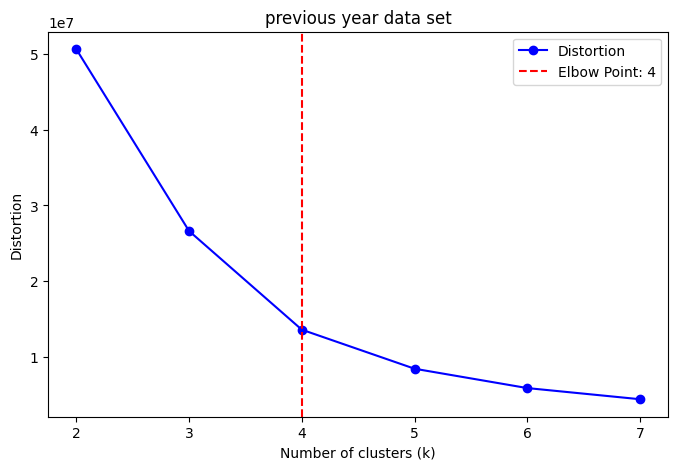

In [7]:
drop_col = ['phone', 'diversity', 'cus_name', 'aov']
def find_k(data, timming='last', drop_col = ['phone']): 
    distortions = [] 
    K = range(2, 8) 
    for k in K: 
        kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++')
        kmeans.fit(data.drop(drop_col, axis=1))
        distortions.append(kmeans.inertia_)
        
    knee_locator = KneeLocator(K, distortions, curve="convex", direction="decreasing")
    elbow_point = knee_locator.knee

    plt.figure(figsize=(8, 5))
    plt.plot(K, distortions, 'bo-', label='Distortion')
    plt.axvline(x=elbow_point, color='red', linestyle='--', label=f'Elbow Point: {elbow_point}')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Distortion')
    plt.title(f'{timming} year data set')
    plt.legend()
    plt.show()
    return elbow_point
    
k = find_k(previous_norm_data, drop_col = drop_col, timming='previous')

In [8]:
kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++')
kmeans.fit(previous_norm_data.drop(drop_col, axis=1))

## standardized data
previous_norm_data['cluster'] = kmeans.labels_
current_norm_data['cluster'] = kmeans.predict(current_norm_data.drop(drop_col, axis=1))

## original data
prev_merge = prev_data.merge(previous_norm_data[['phone', 'cluster']], on='phone', how='inner')
current_merge = current_data.merge(current_norm_data[['phone', 'cluster']], on='phone', how='inner')

In [9]:
prev_merge

,phone,cus_name,recency,first_ord,frequency,monetary,diversity,aov,cluster
0,@0916141972,Tuyết Hạnh Nguyễn,151.0,214,1.0,980000.0,6.0,980000.0,0
1,@0911099696,Nguyễn Thị Lan Quế,200.0,165,2.0,621000.0,5.5,310500.0,0
2,@0981908316,Ha Trang,178.0,187,1.0,991000.0,6.0,991000.0,0
3,@0931322691,Hồng ánh,211.0,154,1.0,984000.0,6.0,984000.0,3
4,@0913117667,Diệu nhàn,230.0,135,1.0,1001700.0,6.0,1001700.0,3
...,...,...,...,...,...,...,...,...,...
46180,@0979092891,Nguyễn Hiền,228.0,7,2.0,685000.0,1.5,342500.0,1
46181,@0983316291,Lê Thanh Lan,206.0,158,2.0,743200.0,1.5,371600.0,3
46182,@0369369882,Xuân Thị Vân,111.0,248,2.0,476000.0,1.5,238000.0,2
46183,@0981767679,Mon Mon,100.0,106,2.0,847000.0,1.5,423500.0,3


In [10]:
label = {
    1 : 'Likedly churn',
    2 : 'Potentially valuable', 
    3 : 'Valuable',
    4 : 'Best'
}

# M > R > F (3 2 1)
components_comparisons = {('R', 'F'): 2/1, ('R', 'M'): 2/3, ('F', 'M'): 1/3}
weight_rfm = ahpy.Compare(name='rfm', comparisons=components_comparisons, precision=3, random_index='saaty')

cr = weight_rfm.consistency_ratio
rfm_weight = weight_rfm.target_weights

if cr < 0.1:
    print(rfm_weight)
else: 
    print('cr > 10%')

{'M': 0.5, 'R': 0.333, 'F': 0.167}


In [11]:
prev_center_matrix = previous_norm_data.groupby(by='cluster')[['recency', 'frequency', 'monetary']].agg(['mean']).values
prev_clv = np.sum(prev_center_matrix * np.array([rfm_weight['R'], rfm_weight['F'], rfm_weight['M']]), axis=1)

prev_clv_df = pd.DataFrame(
    {
        'cluster' : range(len(prev_clv)),
        'clv' : prev_clv,
    }
)
prev_clv_df['rank'] = prev_clv_df['clv'].rank(ascending=True)
prev_clv_df['label'] = prev_clv_df['rank'].map(label)
prev_clv_df

,cluster,clv,rank,label
0,0,0.336614,2.0,Potentially valuable
1,1,0.597308,4.0,Best
2,2,0.441471,3.0,Valuable
3,3,0.277341,1.0,Likedly churn


In [12]:
label = dict(prev_clv_df[['cluster', 'label']].values)

current_center_matrix = current_norm_data.groupby(by='cluster')[['recency', 'frequency', 'monetary']].agg(['mean']).values
current_clv = np.sum(current_center_matrix * np.array([rfm_weight['R'], rfm_weight['F'], rfm_weight['M']]), axis=1)

current_clv_df = pd.DataFrame(
    {
        'cluster' : range(len(current_clv)),
        'clv' : current_clv,
    }
)
current_clv_df['label'] = current_clv_df['cluster'].map(label)
current_clv_df

,cluster,clv,label
0,0,0.360096,Potentially valuable
1,1,0.567622,Best
2,2,0.439823,Valuable
3,3,0.295365,Likedly churn


In [13]:
## assign segment label
prev_merge['label'] = prev_merge['cluster'].map(label)
current_merge['label'] = current_merge['cluster'].map(label)

In [14]:
# 1: prev, 2: current
df=prev_merge.merge(current_merge, how='outer'
                    , left_on=['phone', 'cus_name'], right_on=['phone', 'cus_name']
                    , suffixes=("_1", "_2"))
df.label_1.loc[df[(df.label_1.isna()) & (~df.label_2.isna())]['label_1'].index] = 'Unknown'
df.label_2.loc[df[(~df.label_1.isna()) & (df.label_2.isna())]['label_2'].index] = 'Churn customer'

In [15]:
grouped = (
    df.groupby(['label_1', 'label_2'])
    .agg(
        count=('phone', 'size'),           
        total_monetary_1=('monetary_1', 'sum'),
        total_monetary_2=('monetary_2', 'sum') 
    )
    .reset_index()
)

# Tính phần trăm cho từng nhóm dựa trên tổng count
grouped['%_count'] = grouped['count'] / grouped['count'].sum()
grouped['%m_last_year'] = grouped['total_monetary_1'] / grouped['total_monetary_1'].sum()
grouped['%m_current_year'] = grouped['total_monetary_2'] / grouped['total_monetary_2'].sum()


# Thêm dòng tổng cộng
total_row = {
    'label_1': np.nan,
    'label_2': np.nan,
    'count': grouped['count'].sum(),
    'total_monetary_1': grouped['total_monetary_1'].sum(),
    'total_monetary_2': grouped['total_monetary_2'].sum(),
    '%m_last_year' : 1, 
    '%m_current_year' : 1, 
    '%_count': 1  # 100% tổng count
}

grouped = pd.concat([grouped, pd.DataFrame([total_row])], ignore_index=True)

grouped[['label_1', 'label_2', 'count', '%_count', 'total_monetary_1', '%m_last_year', 'total_monetary_2', '%m_current_year']].sort_values(by='%_count', ascending=False)

,label_1,label_2,count,%_count,total_monetary_1,%m_last_year,total_monetary_2,%m_current_year
24,NaN,NaN,93217,1.000000,2.656033e+10,1.000000,2.908615e+10,1.000000
16,Unknown,Likedly churn,19433,0.208471,0.000000e+00,0.000000,1.156598e+10,0.397646
11,Potentially valuable,Churn customer,16088,0.172587,8.918922e+09,0.335799,0.000000e+00,0.000000
17,Unknown,Potentially valuable,15292,0.164047,0.000000e+00,0.000000,8.881452e+09,0.305350
6,Likedly churn,Churn customer,14679,0.157471,8.655001e+09,0.325862,0.000000e+00,0.000000
20,Valuable,Churn customer,11263,0.120826,6.251425e+09,0.235367,0.000000e+00,0.000000
18,Unknown,Valuable,10219,0.109626,0.000000e+00,0.000000,5.662965e+09,0.194696
15,Unknown,Best,2088,0.022399,0.000000e+00,0.000000,1.482904e+09,0.050983
1,Best,Churn customer,1691,0.018140,1.253275e+09,0.047186,0.000000e+00,0.000000
12,Potentially valuable,Likedly churn,382,0.004098,2.177404e+08,0.008198,2.319730e+08,0.007975


In [28]:
remain = df[(df.label_1 != 'Unknown') & (df.label_2 != 'Churn customer')]
remain = remain.groupby(['label_1', 'label_2']).agg(count=('phone', 'count'),
                                           aov1 = ('aov_1', 'mean'),
                                           aov2 = ('aov_2', 'mean'),
                                           monetary1=('monetary_1', 'mean'),
                                           monetary2=('monetary_2', 'mean')).reset_index()


remain[(remain.label_1 == 'Best') | (remain.label_2 == 'Best')]

,label_1,label_2,count,aov1,aov2,monetary1,monetary2
0,Best,Best,13,380512.692308,325308.461538,761025.384615,650616.923077
1,Best,Likedly churn,51,370951.754902,443777.980392,741903.509804,579791.254902
2,Best,Potentially valuable,45,371972.511111,456349.533333,743945.022222,603073.977778
3,Best,Valuable,25,384389.200000,492131.200000,768778.400000,601193.200000
4,Likedly churn,Best,62,472791.048387,333240.040323,643626.451613,666480.080645
8,Potentially valuable,Best,61,467170.491803,338222.163934,579851.639344,676444.327869
12,Valuable,Best,42,468194.285714,372264.619048,549727.380952,744529.238095
